##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

import matplotlib.pyplot as plt
from wordcloud import WordCloud

### <u>Split training and testing data</u> ###

**Learning curve**

In [2]:
df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

In [3]:
def generate_learning_curve(df, classifier, y_min=0.5, y_max=1.0):
    X = df['text']
    y = df['sentiment']
        
    tfidf_pipeline = make_pipeline(TfidfVectorizer(), classifier)
    train_sizes, train_scores, test_scores = learning_curve(tfidf_pipeline, X, y, train_sizes=np.arange(0.1, 1.0, 0.1))
    
    plt.subplots(1, figsize=(8, 5))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label = 'Training Score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label = 'Test Score')
    plt.xlabel('Training proportion (%)')
    plt.xticks(train_sizes, labels=(np.arange(0.1, 1.0, 0.1)*100).astype(int))
    plt.ylim((y_min, y_max))
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

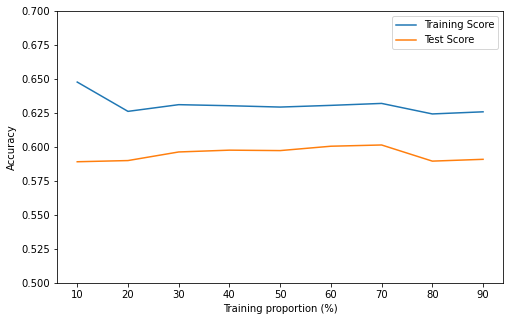

In [9]:
generate_learning_curve(df, MultinomialNB(), 0.5, 0.7)

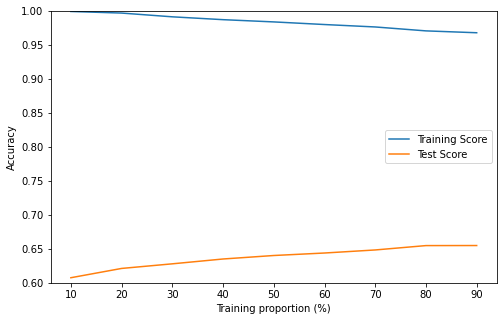

In [10]:
generate_learning_curve(df, svm.LinearSVC(), 0.6, 1.0)

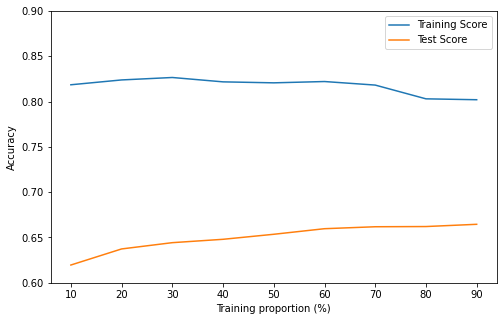

In [11]:
generate_learning_curve(df, LogisticRegression(max_iter=300), 0.6, 0.9)

**Function**

In [4]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.3

def data_split(df, test_size=TEST_SIZE):
    X = df['text']
    y = df['sentiment']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

### <u>Feature vectorization</u> ###

In [5]:
def vectorise(train, test, method):
    vectorizer = method
    
    vectorised_train = vectorizer.fit_transform(train)
    vectorised_test = vectorizer.transform(test)
    
    return vectorised_train, vectorised_test

### <u>Fitting, predicting and evaluation</u> ###

In [6]:
def evaluate(actual_classes, pred_classes, accuracy=True, fscore=True, confusion=True, average_method='macro'):
    if accuracy:
        accuracy = accuracy_score(actual_classes, pred_classes)   
        print('Accuracy:', accuracy)

    if fscore:
        precision, recall, fscore, support = precision_recall_fscore_support(actual_classes, pred_classes, 
                                                                    labels=['positive', 'negative', 'neutral'],
                                                                   average=average_method,
                                                                    zero_division=0)
        print('Precision:', precision)
        print('Recall:', recall)
        print('Fscore:', fscore)
    
    if confusion:
        confusion_display = pd.DataFrame(confusion_matrix(actual_classes, pred_classes, labels=['positive', 'negative', 'neutral']),
                                        index=['actual: positive', 'actual: negative', 'actual: neutral'],
                                        columns=['pred: positive', 'pred: negative', 'pred: neutral'])
        print('Confusion matrix:\n', confusion_display)
    
    print('')

In [7]:
def fit_predict_evaluate(X_train, y_train, X_test, y_test,
                         base_models, titles, display='all', meta_classifier='logistic',
                         accuracy=True, fscore=True, confusion=True, average_method='macro'):
    # base models
    if display == 'base' or display == 'all':
        for title, model in zip(titles, base_models): 
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            print(title)
            evaluate(y_test, pred, accuracy=accuracy, fscore=fscore, confusion=confusion, average_method=average_method)

    # stacked model
    if display == 'stacked' or display == 'all':
        # format base models for stacking classifier input
        zipped_models = [list(model) for model in zip(titles, base_models)][1:]
        if meta_classifier == 'logistic':
            stack_model = StackingClassifier(estimators=zipped_models, final_estimator=LogisticRegression(max_iter=300))
        elif meta_classifier == 'decision-tree':
            stack_model = StackingClassifier(estimators=zipped_models, final_estimator=DecisionTreeClassifier())
        
        stack_model.fit(X_train, y_train)
        stack_pred = stack_model.predict(X_test)
        print('Stacked model')
        evaluate(y_test, stack_pred, accuracy=accuracy, fscore=fscore, confusion=confusion, average_method=average_method)

### <u>Data cleaning and stemming</u> ###

#### Functions ####

In [8]:
import re
from nltk.corpus import stopwords

def clean(texts, feature=None, remove_instance=True, replace_instance=False):
    cleaned_text = texts
    if feature == 'username' or feature == 'all':
        if remove_instance:
            pattern = r'@(\w+)+'
        else:
            pattern = r'@'
        cleaned_text = cleaned_text.str.replace(pattern, '', regex=True)
        
    if feature == 'hashtag' or feature == 'all':
        if remove_instance:
            pattern = r'#(\w+)+'
        else:
            pattern = r'#'
        cleaned_text = cleaned_text.str.replace(pattern, '', regex=True)
    
    if feature == 'url' or feature == 'all':
        if replace_instance:
            token = 'URL'
        else:
            token = ''
        cleaned_text = cleaned_text.str.replace(r'https?:\/\/\S+', token, regex=True)
        
    if feature == 'non-alphanumeric' or feature == 'all':
        cleaned_text = cleaned_text.str.replace(r'[^a-zA-Z0-9 #]', '', regex=True)
    
    return cleaned_text

def remove_stopwords(texts):
    stop_words = set(stopwords.words('english'))
    tokenized_texts = texts.str.split(' ')
    tokenized_texts = tokenized_texts.apply(lambda sentence: [word for word in sentence if word not in stop_words])
    return tokenized_texts.str.join(' ')
    
def stem(texts, method):
    tokenized_texts = texts.str.split(' ')
    tokenized_texts = tokenized_texts.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
    return tokenized_texts.str.join(' ')

#### Experiments ####

In [9]:
base_models = [MultinomialNB(),
              svm.LinearSVC(),
              LogisticRegression(max_iter=300)]

titles = ['Multinomial NB',
          'Linear SVC',
          'Logistic Regression']  

**Removing features one by one + removing whole instances**

In [34]:
features = [None,
            'username',
            'hashtag',
            'url',
            'non-alphanumeric', 
            'all']

# loop over which removes whole instances
for removed_feature in features:
    print('################################################################################################################')
    print('Removing feature:', removed_feature)
    df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

    df['text'] = clean(df['text'], feature=removed_feature)

    X_train, X_test, y_train, y_test = data_split(df)
    
    X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())
    print('# of features: ', X_train_tfidf.shape[1])
    print('')

    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                         base_models, titles, display='base',
                         fscore=False, confusion=False)

################################################################################################################
Removing feature: None
# of features:  34480

Zero-R
Accuracy: 0.583244152270295

Multinomial NB
Accuracy: 0.5933343525454824

Linear SVC
Accuracy: 0.6381287264944198

Logistic Regression
Accuracy: 0.61733679865464

################################################################################################################
Removing feature: username
# of features:  29393

Zero-R
Accuracy: 0.583244152270295

Multinomial NB
Accuracy: 0.5939458798348877

Linear SVC
Accuracy: 0.6367527900932579

Logistic Regression
Accuracy: 0.6207001987463691

################################################################################################################
Removing feature: hashtag
# of features:  32215

Zero-R
Accuracy: 0.583244152270295

Multinomial NB
Accuracy: 0.5919584161443204

Linear SVC
Accuracy: 0.6320134536003669

Logistic Regression
Accuracy: 0.6148906894970187

##

**Comparison of removing the whole instance or just the character for hashtag and usernames**

In [11]:
features = ['username',
            'hashtag']

# loop over which removes whole instances
for removed_feature in features:
    print('################################################################################################################')
    print('Removing feature:', removed_feature)
    for remove_instance in True,False:
        print('Removing entire instance:', remove_instance)
        df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

        df['text'] = clean(df['text'], feature=removed_feature, remove_instance=remove_instance)

        X_train, X_test, y_train, y_test = data_split(df)

        X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

        print('# of features: ', X_train_tfidf.shape[1])
        print('')
        
        fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                             base_models, titles, display='base',
                             fscore=False, confusion=False)
        print('')

################################################################################################################
Removing feature: username
Removing entire instance: True
# of features:  29393

Multinomial NB
Accuracy: 0.5939458798348877

Linear SVC
Accuracy: 0.6509707995719309

Logistic Regression
Accuracy: 0.6592264179789024


Removing entire instance: False
# of features:  34490

Multinomial NB
Accuracy: 0.5933343525454824

Linear SVC
Accuracy: 0.6502063904601743

Logistic Regression
Accuracy: 0.6610609998471182


################################################################################################################
Removing feature: hashtag
Removing entire instance: True
# of features:  32215

Multinomial NB
Accuracy: 0.5919584161443204

Linear SVC
Accuracy: 0.6460785812566886

Logistic Regression
Accuracy: 0.6563216633542271


Removing entire instance: False
# of features:  34520

Multinomial NB
Accuracy: 0.5930285889007797

Linear SVC
Accuracy: 0.6489833358813637

Logist

**Comparison of removing the whole instance or replacing with a token for URLs**

In [30]:
print('################################################################################################################')
print('Removing feature: URLs')
for replace_instance in True,False:
    print('Replacing instance with token:', replace_instance)
    df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

    df['text'] = clean(df['text'], feature='url', replace_instance=replace_instance)

    X_train, X_test, y_train, y_test = data_split(df)

    X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

    print('# of features: ', X_train_tfidf.shape[1])
    print('')

    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                         base_models, titles, display='base',
                         fscore=False, confusion=False)
    print('')

################################################################################################################
Removing feature: URLs
Replacing instance with token: True
# of features:  27925

Zero-R
Accuracy: 0.583244152270295

Multinomial NB
Accuracy: 0.5968506344595628

Linear SVC
Accuracy: 0.639198899250879

Logistic Regression
Accuracy: 0.6176425622993426


Replacing instance with token: False
# of features:  27842

Zero-R
Accuracy: 0.583244152270295

Multinomial NB
Accuracy: 0.5973092799266168

Linear SVC
Accuracy: 0.6395046628955817

Logistic Regression
Accuracy: 0.6161137440758294




**Final feature reduction - only replacing URLs**

In [33]:
df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)


# replace URL
df['text'] = clean(df['text'], feature='url', replace_instance=replace_instance)

# remove non-alphanumeric characters (also removes @ sign from usernames)
df['text'] = clean(df['text'], feature='non-alphanumeric')

X_train, X_test, y_train, y_test = data_split(df)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_models, titles, display='base',
                     fscore=False, confusion=False)

Zero-R
Accuracy: 0.583244152270295

Multinomial NB
Accuracy: 0.5960862253478062

Linear SVC
Accuracy: 0.640116190184987

Logistic Regression
Accuracy: 0.615960862253478



### <u>Data analysis</u> ###

In [14]:
df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)
df['text'] = clean(df['text'], feature='all')

**Wordcloud**

In [15]:
def generate_wordcloud(df, sentiment):
    words = " ".join([tweet for tweet in df['text'][df['sentiment'] == sentiment]])
    wordcloud = WordCloud(random_state=42).generate(words)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud)
    plt.title(sentiment)
    plt.axis('off')
    plt.show()

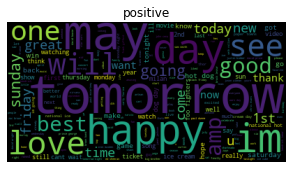

In [24]:
generate_wordcloud(df, 'positive')

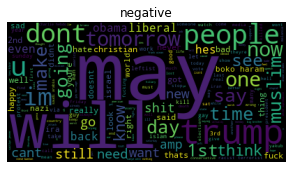

In [25]:
generate_wordcloud(df, 'negative')

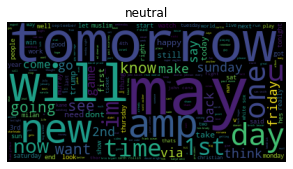

In [26]:
generate_wordcloud(df, 'neutral')

**Sentiment distribution**

Text(0, 0.5, 'Frequency')

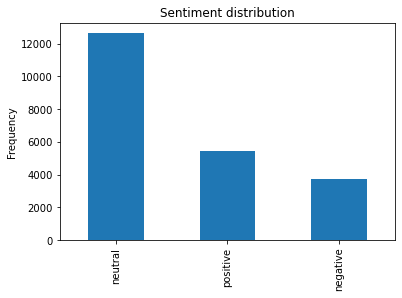

In [16]:
plt.title('Sentiment distribution')
df['sentiment'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')

**Hashtag graph**

In [17]:
def extract_hashtags(df, sentiment):
    tweets = df['text'][df['sentiment'] == sentiment]
    hashtags = []
    
    for tweet in tweets:
        hashtags.append(re.findall(r'#(\w+)+', tweet))
        
    return pd.Series(sum(hashtags, []))

df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

<AxesSubplot:title={'center':'Hashtags for positive sentiment'}, ylabel='Frequency'>

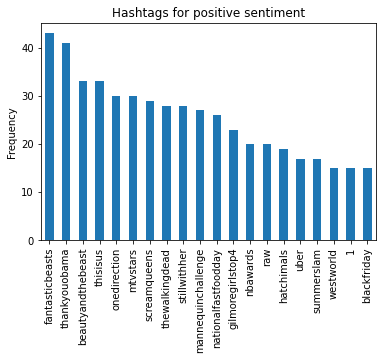

In [38]:
extract_hashtags(df, 'positive').value_counts()[0:20].plot(kind='bar', ylabel = 'Frequency', title = 'Hashtags for positive sentiment')

<AxesSubplot:title={'center':'Hashtags for negative sentiment'}, ylabel='Frequency'>

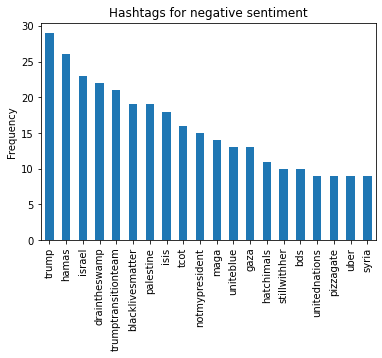

In [39]:
extract_hashtags(df, 'negative').value_counts()[0:20].plot(kind='bar', ylabel = 'Frequency', title = 'Hashtags for negative sentiment')

<AxesSubplot:title={'center':'Hashtags for neutral sentiment'}, ylabel='Frequency'>

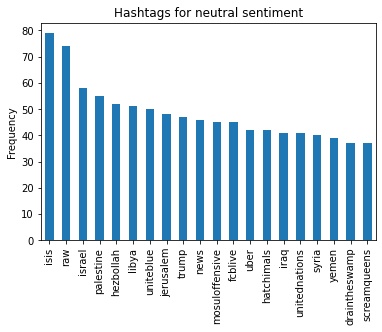

In [40]:
extract_hashtags(df, 'neutral').value_counts()[0:20].plot(kind='bar', ylabel = 'Frequency', title = 'Hashtags for neutral sentiment')

### <u>Sampling distribution experiments</u> ###

In [18]:
base_models = [DummyClassifier(strategy='most_frequent'),
               MultinomialNB(),
              svm.LinearSVC(),
              LogisticRegression(max_iter=300)]

titles = ['Zero-R',
          'Multinomial NB',
          'Linear SVC',
          'Logistic Regression'] 

df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

df['text'] = clean(df['text'], feature='all')

X_train, X_test, y_train, y_test = data_split(df)
X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

**No imbalance method**

In [19]:
fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_models, titles, 
                     fscore=False, confusion=False)

Zero-R
Accuracy: 0.583244152270295

Multinomial NB
Accuracy: 0.6006726800183458

Linear SVC
Accuracy: 0.6427151811649595

Logistic Regression
Accuracy: 0.6581562452224431

Stacked model
Accuracy: 0.65433419966366



**Random under-sampling**

In [20]:
rus = RandomUnderSampler(random_state=42, replacement=True)

X_train_tfidf_rus, y_train_rus = rus.fit_resample(X_train_tfidf, y_train)

fit_predict_evaluate(X_train_tfidf_rus, y_train_rus, X_test_tfidf, y_test, 
                     base_models, titles, fscore=False,
                     confusion=False)

Zero-R
Accuracy: 0.1738266320134536

Multinomial NB
Accuracy: 0.49258523161596085

Linear SVC
Accuracy: 0.5427304693471946

Logistic Regression
Accuracy: 0.5552667787800031

Stacked model
Accuracy: 0.550986087754166



**Random over-sampling**

In [21]:
ros = RandomOverSampler(random_state=42)

X_train_tfidf_ros, y_train_ros = ros.fit_resample(X_train_tfidf, y_train)

fit_predict_evaluate(X_train_tfidf_ros, y_train_ros, X_test_tfidf, y_test, 
                     base_models, titles, fscore=False,
                     confusion=False)

Zero-R
Accuracy: 0.1738266320134536

Multinomial NB
Accuracy: 0.537685369209601

Linear SVC
Accuracy: 0.6072465983794527

Logistic Regression
Accuracy: 0.6234520715486929

Stacked model
Accuracy: 0.6252866534169087



**SMOTE: Synthetic Minority Over-sampling Technique**

In [22]:
smt = SMOTE(random_state=777, k_neighbors=1)

X_train_tfidf_smt, y_train_smt = smt.fit_resample(X_train_tfidf, y_train)

fit_predict_evaluate(X_train_tfidf_smt, y_train_smt, X_test_tfidf, y_test, 
                     base_models, titles, fscore=False,
                     confusion=False)

Zero-R
Accuracy: 0.1738266320134536

Multinomial NB
Accuracy: 0.5402843601895735

Linear SVC
Accuracy: 0.60694083473475

Logistic Regression
Accuracy: 0.6242164806604494

Stacked model
Accuracy: 0.6248280079498547



**Class weight**

In [23]:
base_models = [DummyClassifier(strategy='most_frequent'),
               MultinomialNB(),
              svm.LinearSVC(class_weight='balanced'),
              LogisticRegression(max_iter=300, class_weight='balanced')]

fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_models, titles, 
                     confusion=False)

Zero-R
Accuracy: 0.583244152270295
Precision: 0.19441471742343167
Recall: 0.3333333333333333
Fscore: 0.24559031801210243

Multinomial NB
Accuracy: 0.6006726800183458
Precision: 0.7234771455416329
Recall: 0.36211554017245606
Fscore: 0.30545890974917755

Linear SVC
Accuracy: 0.6271212352851246
Precision: 0.5775341897052667
Recall: 0.5836840771461657
Fscore: 0.5801759902220681

Logistic Regression
Accuracy: 0.6144320440299649
Precision: 0.5800118444757254
Recall: 0.6276238263503018
Fscore: 0.5932967733629576

Stacked model
Accuracy: 0.653416908729552
Precision: 0.6162043168626604
Recall: 0.5543952701552671
Fscore: 0.5743716125023527



### <u>Hyperparameters experiments</u> ###

In [24]:
df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

df['text'] = clean(df['text'], feature='url', replace_instance=True) 

X_train, X_test, y_train, y_test = data_split(df)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

**Multinomial Naive Bayes**

In [23]:
hyperparam_alpha = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]


for alpha in hyperparam_alpha:
    print('################################################################################################################')
    base_model = [MultinomialNB(alpha=alpha)]
    title = ['Multinomial NB, alpha = ' + str(alpha)]
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_model, title, display='base',
                     confusion=False)

################################################################################################################
Multinomial NB, alpha = 0.01
Accuracy: 0.6118330530499924
Precision: 0.5601042139533479
Recall: 0.5033918373893637
Fscore: 0.5202435715107637

################################################################################################################
Multinomial NB, alpha = 0.05
Accuracy: 0.630178871732151
Precision: 0.5893460265827263
Recall: 0.5107683296217097
Fscore: 0.5310315555697565

################################################################################################################
Multinomial NB, alpha = 0.1
Accuracy: 0.6359883809815013
Precision: 0.6084378051772875
Recall: 0.49788993511928076
Fscore: 0.5194382063503079

################################################################################################################
Multinomial NB, alpha = 0.5
Accuracy: 0.616878153187586
Precision: 0.6598960033280341
Recall: 0.39583322536324256
Fscore

**Support Vector Machine**

In [24]:
hyperparam_C = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0]

for C in hyperparam_C:
    print('################################################################################################################')
    base_model = [svm.LinearSVC(C=C, max_iter=5000)]
    title = ['Linear SVC, C = ' + str(C)]
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_model, title, display='base',
                     confusion=False)

################################################################################################################
Linear SVC, C = 0.1
Accuracy: 0.6509707995719309
Precision: 0.6401219966872643
Recall: 0.49410091962656333
Fscore: 0.5110888213374568

################################################################################################################
Linear SVC, C = 0.5
Accuracy: 0.6572389542883351
Precision: 0.6203561538471987
Recall: 0.5587936078205814
Fscore: 0.5781569054334338

################################################################################################################
Linear SVC, C = 1.0
Accuracy: 0.6457728176119859
Precision: 0.602682839697967
Recall: 0.5652903488351098
Fscore: 0.5787957142211285

################################################################################################################
Linear SVC, C = 5.0
Accuracy: 0.6147378076746675
Precision: 0.5655179123357016
Recall: 0.5584389537258699
Fscore: 0.5610800874085617

############

In [25]:
hyperparam_multiclass = ['one v one', 'one v rest']

for multi_class in hyperparam_multiclass:
    print('################################################################################################################')
    if multi_class == 'one v one':
        base_model = [OneVsOneClassifier(svm.LinearSVC())]
    elif multi_class == 'one v rest':
        base_model = [svm.LinearSVC()]
        
    title = ['Linear SVC, multiclass technique = ' + str(multi_class)]
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_model, title, display='base')

################################################################################################################
Linear SVC, multiclass technique = one v one
Accuracy: 0.6549457269530653
Precision: 0.6168200725505005
Recall: 0.5709444023117771
Fscore: 0.5873847175704188
Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive             865              23            701
actual: negative              60             441            636
actual: neutral              510             327           2978

################################################################################################################
Linear SVC, multiclass technique = one v rest
Accuracy: 0.6457728176119859
Precision: 0.602682839697967
Recall: 0.5652903488351098
Fscore: 0.5787957142211285
Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive             865              35            689
actual: negative              82   

**Logistic regression**

In [26]:
hyperparam_C = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0]

for C in hyperparam_C:
    print('################################################################################################################')
    title = ['Logistic Regression, C = ' + str(C)]
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_model, title, display='base',
                     confusion=False)

################################################################################################################
Logistic Regression, C = 0.1
Accuracy: 0.6457728176119859
Precision: 0.602682839697967
Recall: 0.5652903488351098
Fscore: 0.5787957142211285

################################################################################################################
Logistic Regression, C = 0.5
Accuracy: 0.6457728176119859
Precision: 0.602682839697967
Recall: 0.5652903488351098
Fscore: 0.5787957142211285

################################################################################################################
Logistic Regression, C = 1.0
Accuracy: 0.6457728176119859
Precision: 0.602682839697967
Recall: 0.5652903488351098
Fscore: 0.5787957142211285

################################################################################################################
Logistic Regression, C = 5.0
Accuracy: 0.6457728176119859
Precision: 0.602682839697967
Recall: 0.5652903488351098
Fscore: 

**Stacking Meta Classifier**

In [27]:
base_models = [MultinomialNB(),
              svm.LinearSVC(),
              LogisticRegression(max_iter=300)]

titles = ['Multinomial NB',
          'Linear SVC',
          'Logistic Regression'] 

meta_classifiers = ['logistic', 'decision-tree']

for meta_classifier in meta_classifiers:
    print('################################################################################################################')
    print('Stacking meta classifier: ', meta_classifier)
    print('')
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_models, titles, display='stacked', meta_classifier=meta_classifier,
                     confusion=False)


################################################################################################################
Stacking meta classifier:  logistic

Stacked model
Accuracy: 0.6639657544717933
Precision: 0.6328919856752008
Recall: 0.5690069617811234
Fscore: 0.5902339270073925

################################################################################################################
Stacking meta classifier:  decision-tree

Stacked model
Accuracy: 0.5477755694847882
Precision: 0.49173630028889015
Recall: 0.5026858119307923
Fscore: 0.49614511139890477



**TF-IDF Minimum DF**

In [28]:
base_models = [MultinomialNB(),
              svm.LinearSVC(),
              LogisticRegression(max_iter=300)]

titles = ['Multinomial NB',
          'Linear SVC',
          'Logistic Regression'] 

df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

df['text'] = clean(df['text'], feature='all')

X_train, X_test, y_train, y_test = data_split(df)

thresholds = [0, 0.01, 0.05, 0.1, 0.5]

for min_threshold in thresholds:
    print('################################################################################################################')
    print('Minimum document frequency: ', min_threshold)
    print('')
    
    X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer(min_df=min_threshold))
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                         base_models, titles, display='base', 
                         fscore=False, confusion=False)

################################################################################################################
Minimum document frequency:  0

Multinomial NB
Accuracy: 0.6006726800183458

Linear SVC
Accuracy: 0.6427151811649595

Logistic Regression
Accuracy: 0.6581562452224431

################################################################################################################
Minimum document frequency:  0.01

Multinomial NB
Accuracy: 0.6032716709983184

Linear SVC
Accuracy: 0.6185598532334505

Logistic Regression
Accuracy: 0.61733679865464

################################################################################################################
Minimum document frequency:  0.05

Multinomial NB
Accuracy: 0.583244152270295

Linear SVC
Accuracy: 0.5847729704938083

Logistic Regression
Accuracy: 0.5849258523161596

################################################################################################################
Minimum document frequency:  0.1

Multino

### <u>Classification testing main</u> ###

#### Final classification on training set ####

In [15]:
df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

df['text'] = clean(df['text'], feature='url', replace_instance=True)

X_train, X_test, y_train, y_test = data_split(df)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

base_models = [DummyClassifier(strategy='most_frequent'),
              MultinomialNB(alpha=0.05),
              OneVsOneClassifier(svm.LinearSVC(C=0.5)),
              LogisticRegression(max_iter=300)]

titles = ['Zero-R',
          'Multinomial NB',
          'Linear SVC',
          'Logistic Regression']  

fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_models, titles)

Zero-R
Accuracy: 0.583244152270295
Precision: 0.19441471742343167
Recall: 0.3333333333333333
Fscore: 0.24559031801210243
Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive               0               0           1589
actual: negative               0               0           1137
actual: neutral                0               0           3815

Multinomial NB
Accuracy: 0.6284971716862865
Precision: 0.5874744672850071
Recall: 0.5084164125838235
Fscore: 0.5286053806076803
Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive             671              21            897
actual: negative              62             326            749
actual: neutral              440             261           3114

Linear SVC
Accuracy: 0.6598379452683076
Precision: 0.6287091739311113
Recall: 0.5552282543916541
Fscore: 0.5770115428573702
Confusion matrix:
                   pred: positive  pred: negative  pred: 

**Test set final classification**

In [22]:
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

X_train = train_data['text']
y_train = train_data['sentiment']

X_test = test_data['text']

X_train = clean(X_train, feature='url', replace_instance=True)
X_test = clean(X_test, feature='url', replace_instance=True)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

model = LogisticRegression(max_iter=300, class_weight='balanced')
model.fit(X_train_tfidf, y_train)
test_predicted = model.predict(X_test_tfidf)

In [23]:
# output to csv file
output_pd = pd.DataFrame(list(zip(test_data['id'], test_predicted)), columns=['id', 'sentiment'])
output_pd.to_csv('test_predictions.csv', index=False)

In [20]:
from sklearn.linear_model import LogisticRegression

train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

X_train = train_data['text']
y_train = train_data['sentiment']

X_test = test_data['text']

# clean data
X_train = clean(X_train)
X_test = clean(X_test)

X_train = stem(X_train, lemmatizer)
X_test = stem(X_test, lemmatizer)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer(stop_words='english'))

'''
base_models = [MultinomialNB(),
              svm.LinearSVC(class_weight='balanced'),
              LogisticRegression(max_iter=300, class_weight='balanced')]

titles = ['Multinomial NB',
          'Linear SVC',
          'Logistic Regression']  


zipped_models = [list(model) for model in zip(titles, base_models)]
stack_model = StackingClassifier(estimators=zipped_models, final_estimator=LogisticRegression(max_iter=300))

stack_model.fit(X_train_tfidf, y_train)
test_predicted = stack_model.predict(X_test_tfidf)
'''
model = LogisticRegression(max_iter=300, class_weight='balanced')
model.fit(X_train_tfidf, y_train)
test_predicted = model.predict(X_test_tfidf)